In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchinfo import summary
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl

pl.seed_everything(9999)

Global seed set to 9999


9999

In [3]:
#lake mask
mask_random_dir = "data/lakes_random/"
mask_random_paths = os.listdir(mask_random_dir)

mask_random_list = []

for i in mask_random_paths:
    lake_path = mask_random_dir+i
    lake_array = cv2.imread(lake_path, cv2.IMREAD_UNCHANGED)
    lake_array_float = lake_array.astype("float32") / 255.0
    mask_random_list.append(lake_array_float)


In [4]:
data = np.load("data/data.npz")
dem_data = data["dem"]


In [5]:
train = dem_data[:8000]
valid = dem_data[8000:]

In [6]:
valid_mask = np.stack(random.choices(mask_random_list, k=valid.shape[0]))

In [7]:
class DEMTrain(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks
                
        self.dem_transform = A.Compose([
            A.RandomRotate90(p=0.25),
            A.Flip(p=0.25)
        ])
        
        self.mask_transform = A.Compose([
            A.ShiftScaleRotate(p=0.25, scale_limit=0.2, shift_limit=0.2,
                               interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
            A.RandomRotate90(p=0.25),
            A.Flip(p=0.25)
        ])

    def __getitem__(self, idx):

        target = self.array[idx]
        target_transformed = self.dem_transform(image=target)
        target_trans = target_transformed["image"]
        target_tensor = torch.from_numpy(target_trans).unsqueeze(0)
        
        mask = random.choice(self.masks)
        mask_transformed = self.mask_transform(image=mask)
        mask_trans = mask_transformed["image"]
        mask_tensor = torch.from_numpy(mask_trans).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [8]:
class DEMValid(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks

    def __getitem__(self, idx):

        target = self.array[idx]
        target_tensor = torch.from_numpy(target).unsqueeze(0)
        
        mask = self.masks[idx]
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [9]:
train_dataset = DEMTrain(train, mask_random_list)
valid_dataset = DEMValid(valid, valid_mask)


(256, 256)
float32
0.66518885
0.0


<Figure size 432x288 with 0 Axes>

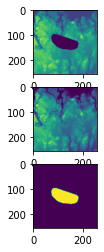

In [10]:
#Example
tmp_in, tmp_target, tmp_mask = train_dataset[0]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

print(tmp_in_np.shape)
print(tmp_in_np.dtype)
print(tmp_in_np.max())
print(tmp_in_np.min())

<Figure size 432x288 with 0 Axes>

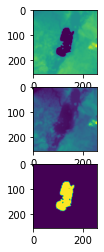

In [35]:
tmp_in_val, tmp_target_val, tmp_mask_val = valid_dataset[5]

tmp_in_val_np = tmp_in.squeeze().numpy()
tmp_target_val_np = tmp_target.squeeze().numpy()
tmp_mask_val_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_val_np)
axarr[1].imshow(tmp_target_val_np)
axarr[2].imshow(tmp_mask_val_np)


In [36]:
from unet_network import UNet

class MSELossWeighted(nn.Module):
    def __init__(self, w_hole = 5, w_nonhole = 1):
        super().__init__()
        self.l2 = nn.MSELoss()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, obs, mask):
        
        l2_hole = self.l2(hat * mask, obs * mask)
        l2_nonhole = self.l2(hat * (1-mask), obs * (1-mask))
        
        l2_total = (l2_hole*self.w_hole) + (l2_nonhole*self.w_nonhole)

        return l2_total
    
class LOGMSELoss(nn.Module):
    def __init__(self, eps = 1):
        super().__init__()
        self.eps = eps

    def forward(self, hat, obs, mask):
        
        loss = torch.log(torch.abs(hat - obs) + eps).mean()

        return loss
    
class LOGMSELossWeighted(nn.Module):
    def __init__(self, w_hole = 5, w_nonhole = 1):
        super().__init__()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, obs, mask):
        
        loss_hole = torch.log(torch.abs((hat * mask) - (obs * mask)) + eps).mean()
        loss_nonhole = torch.log(torch.abs((hat * (1-mask)) - (obs * (1-mask))) + eps).mean()
        
        loss_total = (loss_hole*self.w_hole) + (loss_nonhole*self.w_nonhole)

        return loss_total

In [63]:
class AutoEncoder(pl.LightningModule):
    def __init__(self, init_features = 8, channels = 1):
        super().__init__()
        
        self.save_hyperparameters()
        
        features = init_features
        
        self.unet = UNet(in_channels=channels, out_channels=channels, init_features=features)
        
        self.loss = MSELossWeighted()
        

    def forward(self, x):
        x_hat = self.unet(x)
        return x_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_in, x_obs, x_mask = train_batch
        x_hat=self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        x_in, x_obs, x_mask = val_batch
        x_hat = self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        mse = ((x_hat - x_obs)**2).mean()
        self.log('val_loss', loss),
        self.log('val_mse', mse, on_epoch=True)


In [64]:

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=32, num_workers=8)

# model
model = AutoEncoder(init_features=8)


In [65]:
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
#trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss")])

#load weights
#model = MyLightingModule.load_from_checkpoint(PATH)

#resume training from checkpoint
#trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")


#tb_logger = pl_loggers.TensorBoardLogger("logs/")
#comet_logger = pl_loggers.CometLogger(save_dir="logs/") #use csv logger
#trainer = Trainer(logger=[tb_logger, comet_logger])

#tensorboard --logdir=lightning_logs/


In [66]:
# training

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(gpus=1, 
                     max_epochs=5, 
                     callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

trainer.fit(model, train_loader, val_loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 486 K 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

<Figure size 1200x800 with 0 Axes>

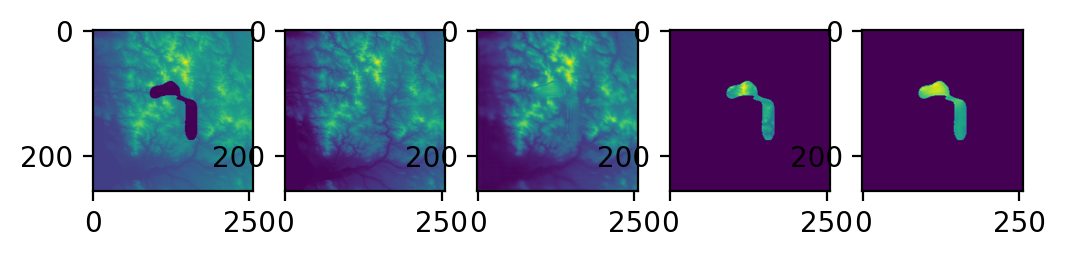

In [67]:
plt.rcParams['figure.dpi'] = 200

tmp_in, tmp_target, tmp_mask = valid_dataset[62]

with torch.no_grad():
    tmp_hat_np = model(tmp_in.unsqueeze(0))
    
tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()
tmp_hat_np = tmp_hat_np.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(1,5)
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_hat_np)
axarr[3].imshow(tmp_target_np * tmp_mask_np)
axarr[4].imshow(tmp_hat_np * tmp_mask_np)


In [68]:
train_transform = A.Compose([
    #A.ShiftScaleRotate(p=0.25, interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
    A.RandomRotate90(p=0.25),
    A.Flip(p=0.25)
])

In [69]:
#rescale range to 0-1 with approximate min-max
def dem_scale(dem, min_val=-25, max_val=175):
    return((dem - min_val)/(max_val - min_val))

def dem_inv_scale(dem_scale, min_val=-25, max_val=175):
    return(dem_scale*(max_val - min_val)+min_val)
  

In [70]:
#dataset for lakes data

class Lakes(Dataset):

    def __init__(self, lakes_list, transform = None):
      
        self.lakes_list = lakes_list
        self.transform = transform

    def __getitem__(self, idx):
        
        list_item = self.lakes_list[idx]
        lake = list_item["lake"]
        mask = list_item["mask"]
        
        lake = dem_scale(lake)

        if self.transform is not None:
            arrays_trans = self.transform(image=lake, mask = mask)
            lake = arrays_trans["image"]
            mask = arrays_trans["mask"]
        
        target_tensor = torch.from_numpy(lake).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor * (1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return len(self.lakes_list)

In [71]:
#remember normalize
#import dict
#original dims in profile
import pickle
with open('data/lakes.pickle', 'rb') as src:
    lakes_list = pickle.load(src)

In [72]:
train_len = int(len(lakes_list)*0.6)
valid_len = int(len(lakes_list)*0.2)
test_len = int(len(lakes_list)*0.2)

print(train_len+valid_len+test_len)

225


In [73]:
random.shuffle(lakes_list)
train_list = lakes_list[:train_len]
valid_list = lakes_list[train_len:(train_len+valid_len)]
test_list = lakes_list[(train_len+valid_len):(train_len+valid_len+test_len)]

print(len(train_list)+len(valid_list)+len(test_list))

225


In [74]:
train_ds = Lakes(train_list, train_transform)
valid_ds = Lakes(valid_list)
test_ds = Lakes(test_list)

<Figure size 1200x800 with 0 Axes>

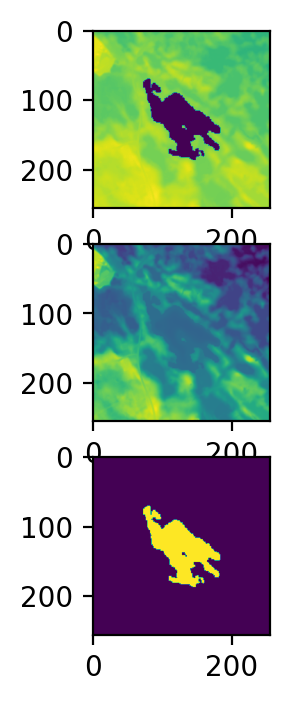

In [75]:
tmp_in, tmp_target, tmp_mask = valid_ds[1]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

In [76]:
train_dl = DataLoader(train_ds, batch_size=32, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=32, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=32, num_workers=4)

In [77]:
lake_model = AutoEncoder.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=4-step=1249.ckpt")

In [78]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=5, 
                     callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

trainer.fit(lake_model, train_dl, valid_dl)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 486 K 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999
/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]